<a href="https://colab.research.google.com/github/andysingal/CaliforniaHousing_Prices/blob/main/Cali_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@ Initialization:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## LIBRARIES


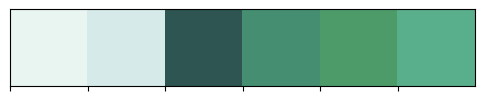

In [23]:

#@ Downloading the Libraries and Dependencies:
import sys, os, tarfile, urllib.request
import numpy as np
import pandas as pd
import IPython


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#@ Visualization Dependencies:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT_DIR = "."
ID = "California Housing"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", ID)
if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving Figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#@ Ignoring the Warnings:
import warnings
warnings.filterwarnings(action="ignore", message="^ internal")

#color pallet and theme
import matplotlib.colors

colors = ["#e9f5f0","#d5eae9","#2e5551",'#468e71','#4d9b68','#59ae8c']
colors2 = ["#2e5551",'#468e71','#4d9b68','#59ae8c', "#e9f5f0","#d5eae9"]
cmap = matplotlib.colors.ListedColormap(colors2)

sns.palplot(sns.color_palette(colors))


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#Download the Data

In [6]:
#@ Getting the Data:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()                                                           # Initializing the Function.

#@ Getting the Data:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

#@ Inspecting the Data:
housing = load_housing_data()
print(pd.Series({"Memory usage": "{:.2f} MB".format(housing.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(housing.shape)}).to_string())
housing.head(7)                            

Memory usage         1.57 MB
Dataset shape    (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


# Exploratory Data Analysis
The analysis report presents that the DataFrame has 20640 rows and each row represents one district. The report also presents that the DataFrame has 10 features where one is categorical and 9 are numerical. The info method is standard and useful to get the quick description of the Data, in particular the attributes type and the number of non null values.

In [8]:
# Shape of the data
print(pd.Series({"Shape of the training set": housing.shape}).to_string())

Shape of the training set    (20640, 10)


In [9]:
# Count of columns
df_cols_count = pd.DataFrame(index = ['Number of columns'], columns = ['Training set'])
df_cols_count['Training set'] = len(housing.columns)
df_cols_count

,Training set
Number of columns,10


In [10]:
# Column names for the training dataset
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [11]:
# Column datatypes for the training dataset
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [12]:
# Integer columns in the training dataset
housing.columns[housing.dtypes == 'int64']

Index([], dtype='object')

In [14]:
# Object columns in the training dataset
housing.columns[housing.dtypes == 'object']

Index(['ocean_proximity'], dtype='object')

In [15]:
# Count of duplicate rows
df_duplicate_rows = pd.DataFrame(index = ['Number of duplicate rows'], columns = ['Training set'])
df_duplicate_rows['Training set'] = housing.duplicated().sum()
df_duplicate_rows

,Training set
Number of duplicate rows,0


In [16]:
# Constant columns in the training set
cols_constant_train = housing.columns[housing.nunique() == 1].tolist()
if len(cols_constant_train) == 0:
    cols_constant_train = "None"
print(pd.Series({"Constant columns in the training set": cols_constant_train}).to_string())

Constant columns in the training set    None


In [17]:
# Count of columns with missing values
df_missing = pd.DataFrame(index = ['Number of columns with missing values'], columns = ['Training set'])
df_missing['Training set'] = len(housing.isna().sum()[housing.isna().sum() != 0])
df_missing

,Training set
Number of columns with missing values,1


In [18]:
# Statistical description of numerical variables in the training set
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). 

Saving Figure attribute_histogram_plots


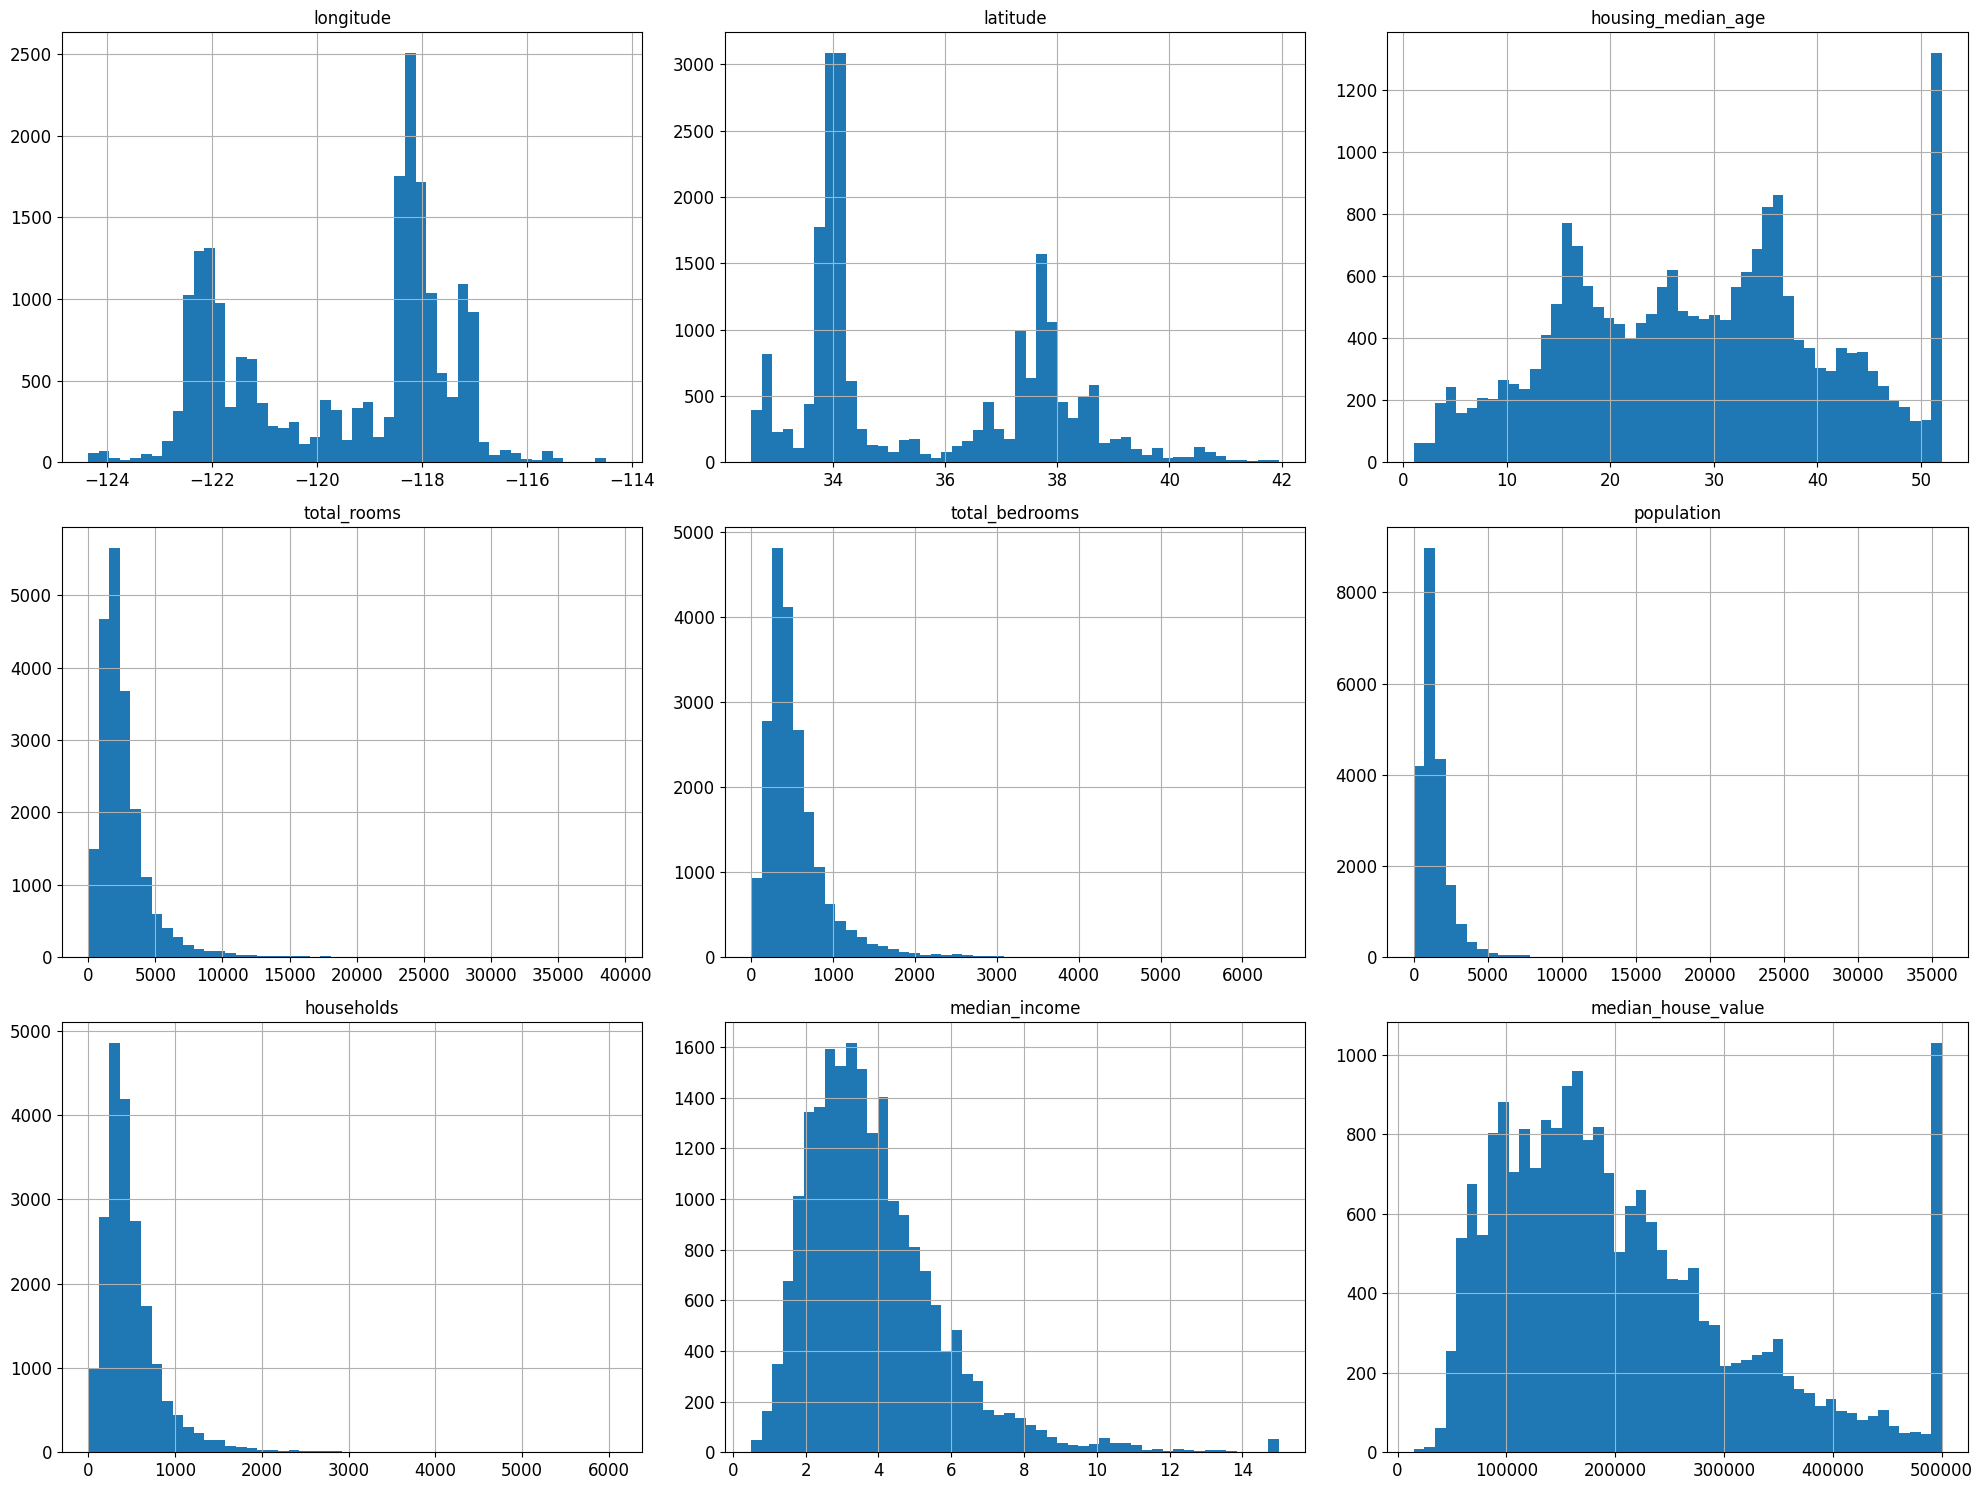

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

There are a few things you might notice in these histograms:

First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:

Collect proper labels for the districts whose labels were capped.

Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

These attributes have very different scales. We will discuss this later in this chapter, when we explore feature scaling.

Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

Processing the Data

I will create a Test Dataset and set them aside. I will pick 20 percent of the instances randomly.

In [24]:
#@ Splitting the Dataset:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=11)

#@ Inspecting the Dataset:
print(f"Training set: {len(train_set)}")                                             # Number of Training Dataset.
print(f"\nTesting set: {len(test_set)}")                                             # Number of Testing Dataset.
IPython.display.display(train_set.head(3))    
print("\n")                    
IPython.display.display(test_set.head(3))

Training set: 16512

Testing set: 4128


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20025,-119.05,36.07,21.0,2472.0,523.0,1238.0,504.0,1.7756,62900.0,INLAND
10772,-117.89,33.66,32.0,2736.0,550.0,1279.0,534.0,5.5422,253100.0,<1H OCEAN
16691,-120.61,35.13,16.0,3431.0,721.0,1777.0,701.0,2.7301,190400.0,<1H OCEAN


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2734,-115.56,32.78,34.0,2856.0,555.0,1627.0,522.0,3.2083,76200.0,INLAND
9087,-118.17,34.66,9.0,1561.0,253.0,731.0,233.0,5.7049,173200.0,INLAND
15789,-122.40,37.78,52.0,464.0,202.0,286.0,148.0,1.6125,112500.0,NEAR BAY


<Axes: >

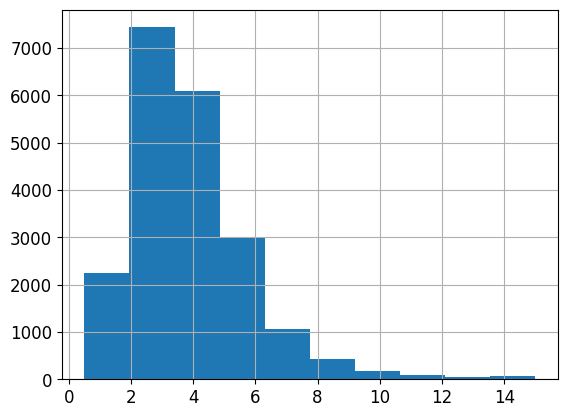

In [25]:
#@ Inspecting the median income attribute:
housing["median_income"].hist()

By observing the Histogram more closely, the values of median income are clustered around 2 and 6 but some median income values goes beyond 6. I will create an income category attribute with 5 categories which are labeled from 1 to 5.

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64




<Axes: >

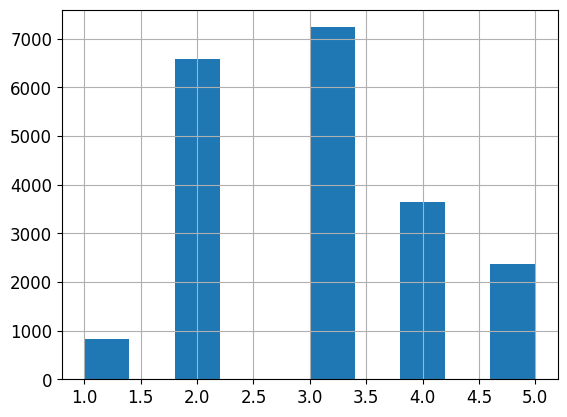

In [26]:
#@ Creating the Income Categories:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

#@ Inspecting the Income Categories:
print(housing["income_cat"].value_counts())
print("\n")
housing["income_cat"].hist()                                      # Inspecting the Income Categories using Histogram.

Stratified Sampling

Now, I will do Stratified Sampling based on the Income Category. I will use Scikit Learn's StratifiedShuffleSplit class for the same.

In [27]:
#@ Stratified Sampling based on Income Category:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

#@ Inspecting the Sampling:
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))            # Income Category Proportions in Test set.
print("\n")
print(housing["income_cat"].value_counts() / len(housing))                          # Income Category Proportions in Full Dataset.

#@ Comparing the Proportions:
def income_cat_propotions(data):
  return data["income_cat"].value_counts() / len(data)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=11)     # Splitting the Dataset.
compare_props = pd.DataFrame({
    "Overall": income_cat_propotions(housing),                                      # Full Dataset.
    "Stratified": income_cat_propotions(strat_test_set),                            # Stratified Sampling Dataset.
    "Random": income_cat_propotions(test_set)                                       # Random Smapling Dataset.
}).sort_index()
compare_props["Random % Error"] = 100 * compare_props["Random"] / compare_props["Overall"] -100
compare_props["Stratified % Error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] -100

#@ Inspecting the Proportions:
print("\n")
IPython.display.display(compare_props)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64




,Overall,Stratified,Random,Random % Error,Stratified % Error
1,0.039826,0.039971,0.032946,-17.274939,0.364964
2,0.318847,0.318798,0.312984,-1.838626,-0.015195
3,0.350581,0.350533,0.353440,0.815368,-0.013820
4,0.176308,0.176357,0.184835,4.836494,0.027480
5,0.114438,0.114341,0.115795,1.185436,-0.084674


In [28]:
#@ Removing the Income Cat from the Data:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

## Exploratory Data Analysis
So far, I have only taken the quick glance at the Data to get the general understanding of the Data. Now, the goal is to go little more in the depth.
Visualizing the Geographical Data

Since, there is a Geographical Information latitude and longitude it will be a good idea to create the scatter plot of all districts to visualize the Data. I will use alpha option to 0.1 which makes it much easier to visualize the places where there is high density of data points.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Saving Figure Geographical Plot


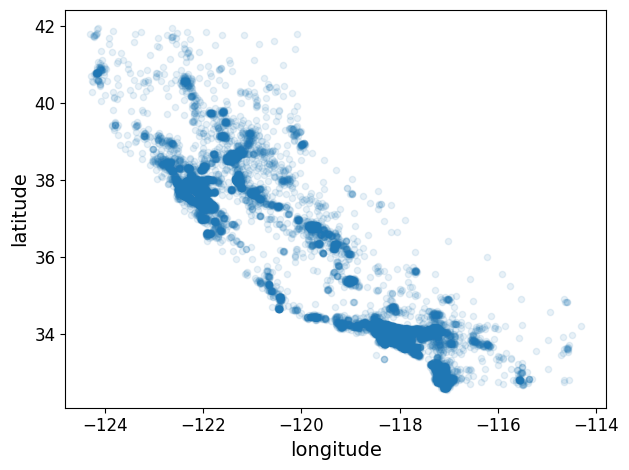

In [29]:
#@ Creating the copy of the Training set:
housing = strat_train_set.copy()

#@ Visualizing the Geographical Data:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("Geographical Plot")



*   Now, let's look at the Housing prices. The radius of each circle represents the district's population option s, the color represents the price option c and I will use predefined color map option cmap called jet which ranges from blue low values and red high values.



Saving Figure Geographical Plots


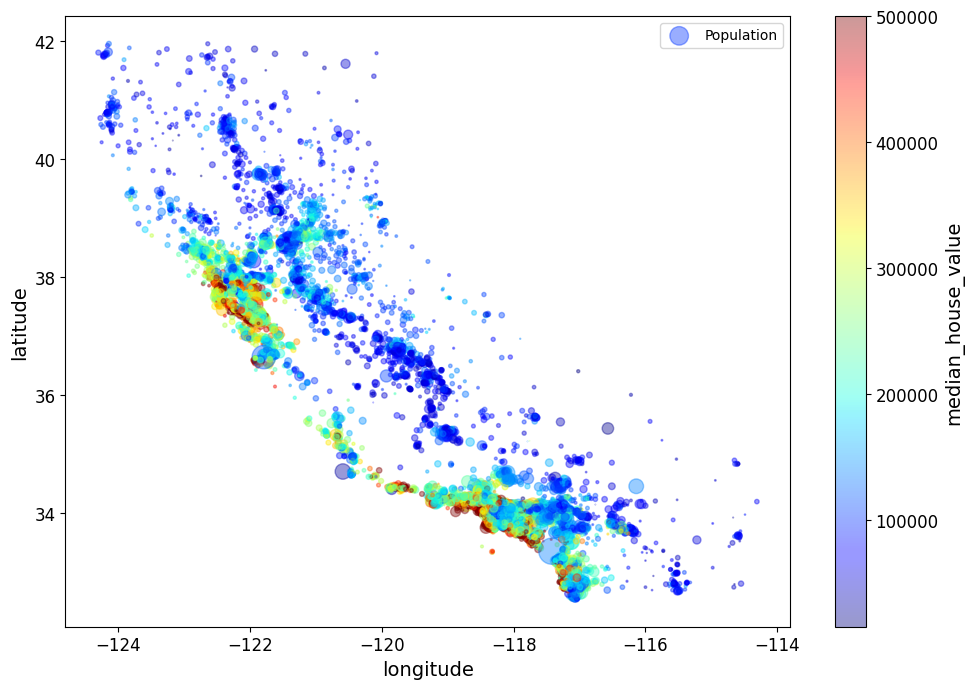

In [30]:
#@ Visualizing the Housing Prices:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="Population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, 
             sharex=False)
plt.legend()
save_fig("Geographical Plots")



*   The Image tells that the Housing prices are very much related to the location and to the population density. It will probably be useful to use a clustering algorithm to detect the main clusters and add new features that measures the proximity to the cluster centres.

**Correlations**


*   Now, I will compute the standard correlation coefficient betweeen every pair of the attributes using corr method.






In [31]:
#@ Correlations:
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))   

median_house_value    1.000000
median_income         0.687829
total_rooms           0.136194
housing_median_age    0.100138
households            0.065931
total_bedrooms        0.050729
population           -0.026367
longitude            -0.043233
latitude             -0.147857
Name: median_house_value, dtype: float64


Saving Figure Correlations


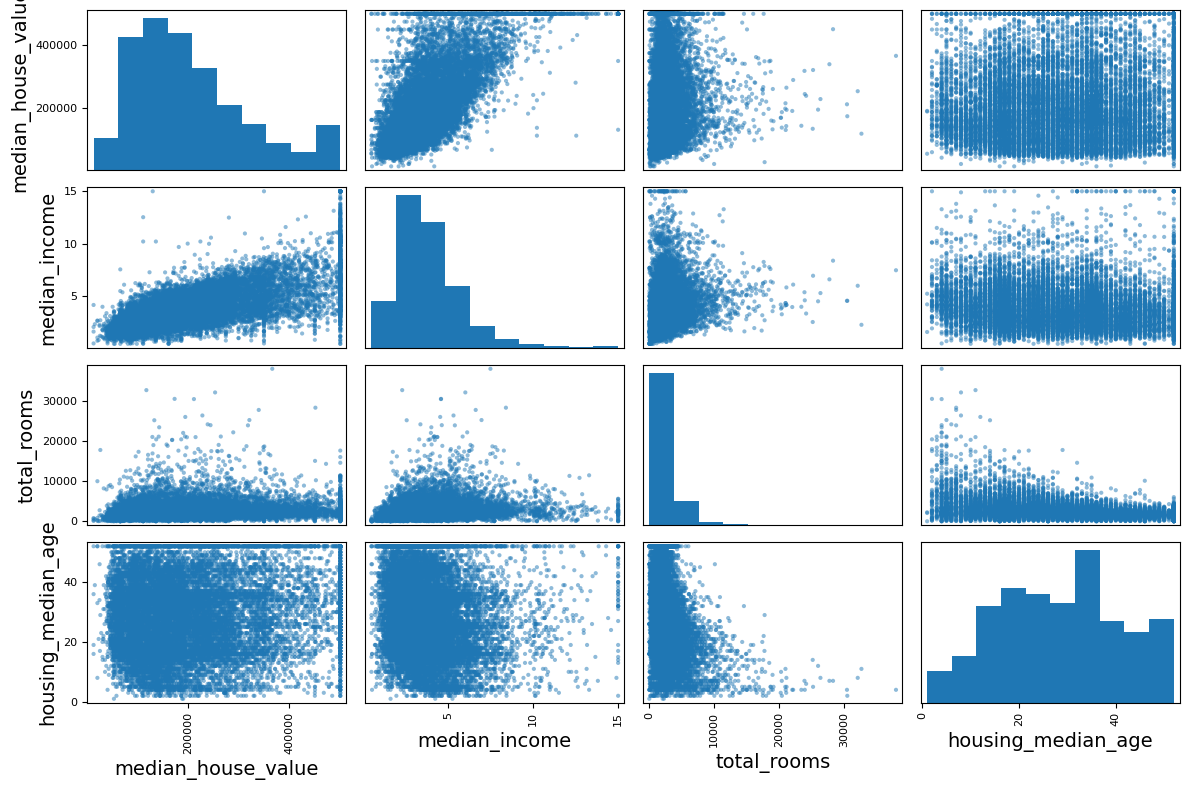

In [32]:
#@ Correlations using Scatter matrix:

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("Correlations")

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Saving Figure Median House value vs Median Income


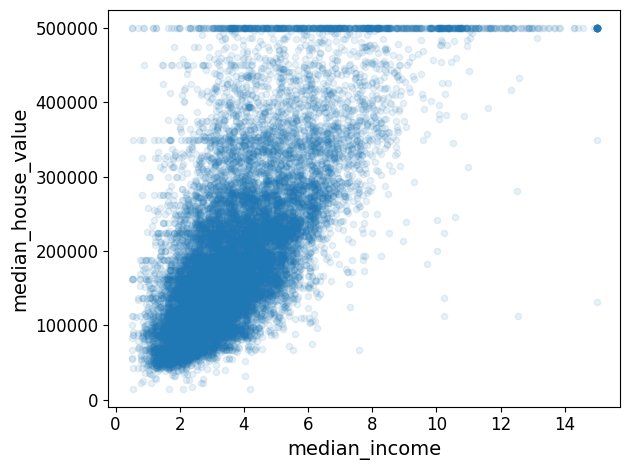

In [33]:
#@ Correlations of Median House Value with Median Income. 
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
save_fig("Median House value vs Median Income")

Attribute Combinations

* I will create the number of rooms per household, the total number of bedrooms 

per rooms and the total number of populations per household.

In [34]:
#@ Attribute Combinations:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]   # Rooms per Household.
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] # Bedrooms per Room.
housing["population_per_household"] = housing["population"]/housing["households"] # Populations per Household.

#@ Inspecting the Correlations:
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

#@ Inspecting the Data:
print("\n")
housing.describe()
     

median_house_value          1.000000
median_income               0.687829
rooms_per_household         0.172937
total_rooms                 0.136194
housing_median_age          0.100138
households                  0.065931
total_bedrooms              0.050729
population_per_household   -0.022292
population                 -0.026367
longitude                  -0.043233
latitude                   -0.147857
bedrooms_per_room          -0.260075
Name: median_house_value, dtype: float64




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16343.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16343.000000,16512.000000
mean,-119.577814,35.642869,28.623123,2621.339995,534.391727,1419.420179,496.418060,3.869816,206525.148740,5.419483,0.212982,3.111527
std,2.004481,2.141427,12.581950,2147.395386,413.642527,1126.132770,375.015774,1.902213,115370.175603,2.150152,0.057695,11.604931
min,-124.300000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.888889,0.100000,0.750000
25%,-121.800000,33.940000,18.000000,1445.000000,296.000000,792.000000,280.000000,2.562175,119400.000000,4.442941,0.175460,2.429049
50%,-118.500000,34.260000,29.000000,2125.000000,434.000000,1166.000000,409.000000,3.531300,179200.000000,5.227585,0.203221,2.819702
75%,-118.010000,37.720000,37.000000,3136.000000,644.000000,1716.000000,601.000000,4.750000,264600.000000,6.056917,0.239637,3.286276
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,62.422222,1.000000,1243.333333
